In [1]:
import math
import random
import numpy as np

import scipy.optimize as sopt

import tensorflow as tf
import tensorflow.keras as keras

from matplotlib import pyplot as plt
import plotly.graph_objects as go 

from pprint import pprint

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd '/content/drive/My Drive/Colab Notebooks'  
# %ls

# Load the TensorBoard notebook extension
# %load_ext tensorboard
# from datetime import datetime
# from packaging import version

# print("TensorFlow version: ", tf.__version__)

In [3]:
# Code to use the scipy optimizers

def function_factory(model, x_train, y_train, x_val=None, y_val=None,
                     iprint=-1):
    """A factory to create a function required by scipy.optimize.
    Args:
        model [in]: an instance of `tf.keras.Model` or its subclasses.
        loss [in]: a function with signature loss_value = loss(pred_y, true_y).
        x_train [in]: input for training data.
        y_train [in]: output for training data.
        x_val [in]: input for validation data.
        y_val [in]: output for validation data.        
    Returns:
        A function that has a signature of:
            loss_value, gradients = f(model_parameters).
    """

    # obtain the shapes of all trainable parameters in the model
    shapes = tf.shape_n(model.trainable_variables)
    n_tensors = len(shapes)

    # we'll use tf.dynamic_stitch and tf.dynamic_partition later, so we need to
    # prepare required information first
    count = 0
    idx = []  # stitch indices
    part = []  # partition indices

    for i, tensor in enumerate(model.trainable_variables):
        n = np.product(tensor.shape)
        idx.append(tf.reshape(
            tf.range(count, count+n, dtype=tf.int32), tensor.shape))
        part.extend([i]*n)
        count += n

    part = tf.constant(part)

    @tf.function
    def assign_new_model_parameters(params_1d):
        """A function updating the model's parameters with a 1D tf.Tensor.
        Args:
            params_1d [in]: a 1D tf.Tensor representing the model's trainable parameters.
        """
        params = tf.dynamic_partition(params_1d, part, n_tensors)
        for i, (shape, param) in enumerate(zip(shapes, params)):
            model.trainable_variables[i].assign(tf.reshape(param, shape))

    # function to calculate loss value and gradient
    @tf.function
    def tf_tape_grad(params_1d):

        # update the parameters in the model
        assign_new_model_parameters(params_1d)       

        if not (x_val is None):
          # compute validation loss
          loss_value = model.loss(y_val, model(x_val))
          # store validation value so we can retrieve later        
          tf.py_function(value_and_grad.hist_loss_val.append,
                        inp=[loss_value], Tout=[])         
              
        # use GradientTape so that we can calculate the gradient of loss w.r.t. parameters
        with tf.GradientTape() as tape:
            tape.watch(model.trainable_variables)
            # run the model
            y_model = model(x_train, training=True)            
            # pprint(vars(model))
            # loss value
            pred_loss = model.loss(y_train, y_model)
            # regularization loss
            regularization_loss = tf.cast( tf.reduce_sum(model.losses), tf.float64)            
            # total loss
            total_value = pred_loss + regularization_loss

        # calculate gradients and convert to 1D tf.Tensor
        grads = tape.gradient(total_value, model.trainable_variables)
        grads = tf.dynamic_stitch(idx, grads)

        # increment iteration counter
        value_and_grad.iter.assign_add(1)

        # print out iteration & loss
        if (iprint >= 0 and value_and_grad.iter % iprint == 0):
            tf.print("Loss function eval:", value_and_grad.iter,
                     "loss:", pred_loss, 
                     "regularization:", regularization_loss,
                     "total:", total_value)

        # store loss value so we can retrieve later
        tf.py_function(value_and_grad.hist_loss.append,
                       inp=[total_value], Tout=[])       

        return total_value, grads

    # create function that will be returned by this factory
    def value_and_grad(params_1d):
        """A function that can be used by optimizer.
        This function is created by function_factory.
        Args:
           params_1d [in]: a 1D tf.Tensor.
        Returns:
            A scalar loss and the gradients w.r.t. the `params_1d`.
        """
        return [vv.numpy().astype(np.float64) for vv in tf_tape_grad(tf.constant(params_1d, dtype=tf.float64))]

    # store this information as members so we can use it outside the scope
    value_and_grad.iter = tf.Variable(0)
    value_and_grad.idx = idx
    value_and_grad.part = part
    value_and_grad.shapes = shapes
    value_and_grad.assign_new_model_parameters = assign_new_model_parameters
    value_and_grad.hist_loss = []
    value_and_grad.hist_loss_val = []

    return value_and_grad


def train_DNN(model, x_t, y_t, x_val=None, y_val=None,  maxiter=1000, iprint=-1,
              figname = None):

    value_and_grad = function_factory(model, x_t, y_t, x_val, y_val,
                                      iprint)

    # convert initial model parameters to a 1D tf.Tensor
    init_params = tf.dynamic_stitch(
        value_and_grad.idx, model.trainable_variables)

    if (iprint>=0):
      print()

    # train the model
    method = 'L-BFGS-B'
    results = sopt.minimize(fun=value_and_grad, x0=init_params,
                            jac=True, method=method,
                            options={'maxiter': maxiter})

    print("\nConvergence information:")
    print('loss:', results.fun)
    print('number function evaluations:', results.nfev)
    print('number iterations:', results.nit)
    print('success flag:', results.success)
    print('convergence message:', results.message)

    value_and_grad.assign_new_model_parameters(results.x)

    # Plot history of loss
    plt.figure()   
    plt.plot(value_and_grad.hist_loss, label='loss')
    if not (x_val is None): 
      plt.plot(value_and_grad.hist_loss_val, label='validation')
    plt.legend()
    plt.xlabel('epoch')
    plt.yscale('log')
    if x_val is None:    
      plt.title('Training loss')
    else:
      plt.title('Training and validation losses')

    if not (figname is None):
      plt.savefig(figname,dpi=300)

    return results

# Reshape 1D arrays to 2D arrays
def reshape_2d(x):
  return tf.reshape(x,(x.shape[0],1))

In [4]:
# prepare data

# use float64 by default
tf.keras.backend.set_floatx("float64")

# Training set; function is y=x
n_t = 7
x_t = np.reshape( np.linspace(-1.,1.,n_t), (n_t,1) )
y_t_no_noise = np.copy(x_t)

# with noise
y_t = np.copy(x_t)

# add noise
e = 0.2
for i in range(1,6):
  y_t[i] = x_t[i] + e # + random.random() * e
  e = -e

n_v = 8
x_v = np.reshape( np.linspace(-1.,1.,n_v), (n_v,1) )
y_v = np.copy(x_v)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 16        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


Convergence information:
loss: 1.0369894454242967e-07
number function evaluations: 31
number iterations: 27
success flag: True
convergence message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


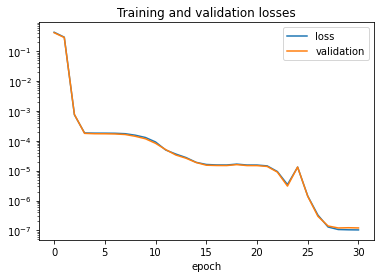

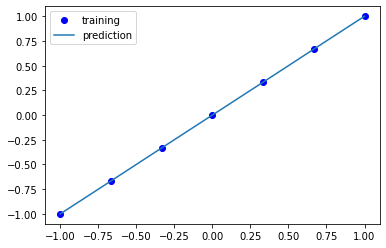

In [5]:
# prepare prediction model, loss function, and the function passed to the optimizer
dnn_8 = keras.models.Sequential()
dnn_8.add(keras.layers.InputLayer(input_shape=1))
dnn_8.add(keras.layers.Dense(8, activation='tanh'))
dnn_8.add(keras.layers.Dense(1, activation="linear"))
dnn_8.compile(loss=tf.keras.losses.MeanSquaredError())
dnn_8.summary()

model = dnn_8

n_epochs = 1000
result = train_DNN(model,x_t,y_t_no_noise,x_val=x_v,y_val=y_v,
                    maxiter=n_epochs, iprint=n_epochs//5)

# Plot DNN solution
plt.figure()
plt.plot(x_t,y_t_no_noise,'bo',label='training')
x_p = np.linspace(-1,1,32)
plt.plot(x_p, np.array(model.predict(x_p)).reshape((x_p.size,)), label='prediction')
plt.legend()
plt.savefig('fig/dnn_8_no_noise.png',dpi=300)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 8)                 16        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


Convergence information:
loss: 3.5408796120878216e-12
number function evaluations: 122
number iterations: 97
success flag: True
convergence message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


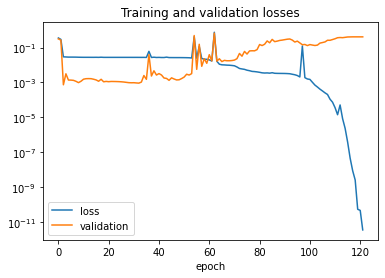

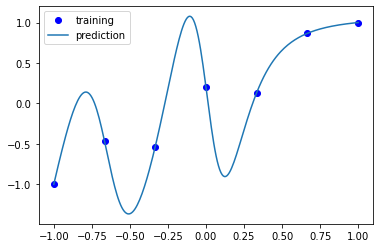

In [6]:
dnn_8 = keras.models.Sequential()
dnn_8.add(keras.layers.InputLayer(input_shape=1))
dnn_8.add(keras.layers.Dense(8, activation='tanh'))
dnn_8.add(keras.layers.Dense(1, activation="linear"))
dnn_8.compile(loss=tf.keras.losses.MeanSquaredError())
dnn_8.summary()
model = dnn_8

result = train_DNN(model,x_t,y_t,x_val=x_v,y_val=y_v,
                   maxiter=n_epochs, iprint=n_epochs//5,
                   figname='fig/dnn_8_noise_loss.png')

# Plot DNN solution
plt.figure()
plt.plot(x_t,y_t,'bo',label='training')
x_p = np.linspace(-1,1,256)
plt.plot(x_p, np.array(model.predict(x_p)).reshape((x_p.size,)), label='prediction')
plt.legend()
plt.savefig('fig/dnn_8_noise.png',dpi=300)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 8)                 16        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________

Convergence information:
loss: 0.027503175660967827
number function evaluations: 26
number iterations: 20
success flag: False
convergence message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'


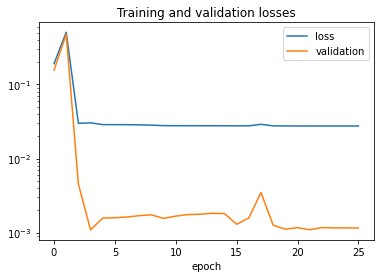

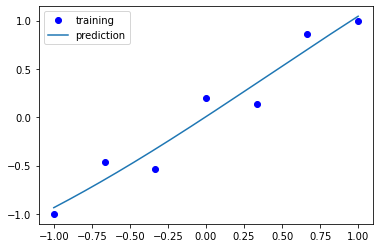

In [7]:
dnn_8 = keras.models.Sequential()
dnn_8.add(keras.layers.InputLayer(input_shape=1))
dnn_8.add(keras.layers.Dense(8, activation='tanh'))
dnn_8.add(keras.layers.Dense(1, activation="linear"))
dnn_8.compile(loss=tf.keras.losses.MeanSquaredError())
dnn_8.summary()
model = dnn_8

result = train_DNN(model,x_t,y_t,x_val=x_v,y_val=y_v,
                   maxiter=20,
                   figname='fig/dnn_8_max20_loss.png')

# Plot DNN solution
plt.figure()
plt.plot(x_t,y_t,'bo',label='training')
x_p = np.linspace(-1,1,256)
plt.plot(x_p, np.array(model.predict(x_p)).reshape((x_p.size,)), label='prediction')
plt.legend()
plt.savefig('fig/dnn_8_max20.png',dpi=300)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 8)                 16        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________

Convergence information:
loss: 0.027424350380897522
number function evaluations: 120
number iterations: 100
success flag: False
convergence message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'


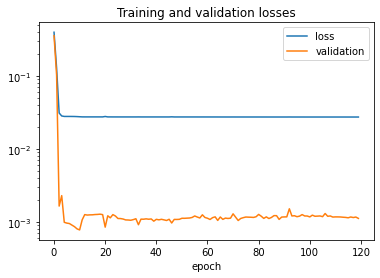

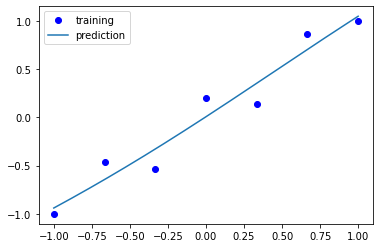

In [8]:
dnn_8 = keras.models.Sequential()
dnn_8.add(keras.layers.InputLayer(input_shape=1))
dnn_8.add(keras.layers.Dense(8, activation='tanh'))
dnn_8.add(keras.layers.Dense(1, activation="linear"))
dnn_8.compile(loss=tf.keras.losses.MeanSquaredError())
dnn_8.summary()
model = dnn_8

result = train_DNN(model,x_t,y_t,x_val=x_v,y_val=y_v,
                   maxiter=100,
                   figname='fig/dnn_8_max100_loss.png')

# Plot DNN solution
plt.figure()
plt.plot(x_t,y_t,'bo',label='training')
x_p = np.linspace(-1,1,256)
plt.plot(x_p, np.array(model.predict(x_p)).reshape((x_p.size,)), label='prediction')
plt.legend()
plt.savefig('fig/dnn_8_max100.png',dpi=300)

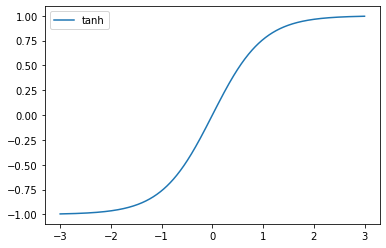

In [9]:
# plot tanh

plt.figure()
x = np.linspace(-3,3,1024)
plt.plot(x, np.tanh(x), label='tanh')
plt.legend()
plt.savefig('fig/tanh.png',dpi=300)


Convergence information:
loss: 6.442781030902012e-11
number function evaluations: 30
number iterations: 23
success flag: True
convergence message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


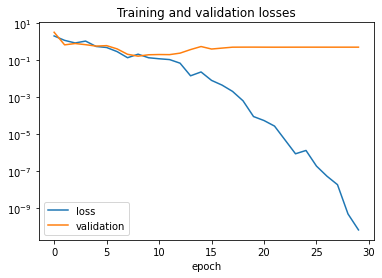

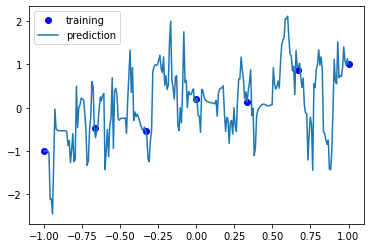

In [10]:
m_val = 10

def layer_128():
  return keras.layers.Dense(128, activation='tanh',
            kernel_initializer=tf.random_uniform_initializer(minval=-m_val, maxval=m_val),
            bias_initializer=tf.random_uniform_initializer(minval=-m_val, maxval=m_val)
          )

dnn_large = keras.models.Sequential()
dnn_large.add(keras.layers.InputLayer(input_shape=1))
dnn_large.add(layer_128())
dnn_large.add(layer_128())
dnn_large.add(layer_128())
dnn_large.add(layer_128())
dnn_large.add(keras.layers.Dense(1, activation="linear"))
dnn_large.compile(loss=tf.keras.losses.MeanSquaredError())

model = dnn_large

result = train_DNN(model,x_t,y_t,x_v,y_v,figname='fig/dnn_large_m10_loss.png')

# Plot DNN solution
plt.figure()
plt.plot(x_t,y_t,'bo',label='training')
x_p = np.linspace(-1,1,256)
plt.plot(x_p, np.array(model.predict(x_p)).reshape((x_p.size,)), label='prediction')
plt.legend()
plt.savefig('fig/dnn_large_m10.png',dpi=300)


Convergence information:
loss: 1.0945117208394084e-11
number function evaluations: 14
number iterations: 12
success flag: True
convergence message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


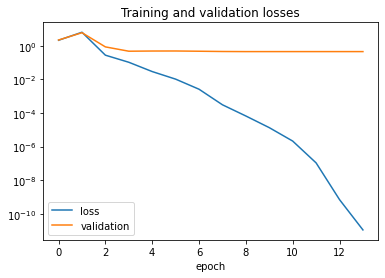

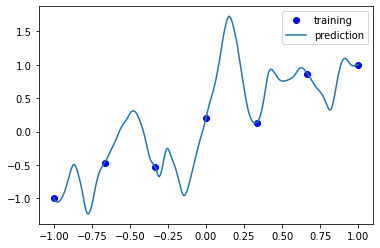

In [11]:
m_val = 1

def layer_128():
  return keras.layers.Dense(128, activation='tanh',
            kernel_initializer=tf.random_uniform_initializer(minval=-m_val, maxval=m_val),
            bias_initializer=tf.random_uniform_initializer(minval=-m_val, maxval=m_val)
          )

dnn_large = keras.models.Sequential()
dnn_large.add(keras.layers.InputLayer(input_shape=1))
dnn_large.add(layer_128())
dnn_large.add(layer_128())
dnn_large.add(layer_128())
dnn_large.add(layer_128())
dnn_large.add(keras.layers.Dense(1, activation="linear"))
dnn_large.compile(loss=tf.keras.losses.MeanSquaredError())

model = dnn_large

result = train_DNN(model,x_t,y_t,x_v,y_v,figname='fig/dnn_large_m1_loss.png')

# Plot DNN solution
plt.figure()
plt.plot(x_t,y_t,'bo',label='training')
x_p = np.linspace(-1,1,256)
plt.plot(x_p, np.array(model.predict(x_p)).reshape((x_p.size,)), label='prediction')
plt.legend()
plt.savefig('fig/dnn_large_m1.png',dpi=300)


Convergence information:
loss: 2.0039961443757415e-12
number function evaluations: 275
number iterations: 204
success flag: True
convergence message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


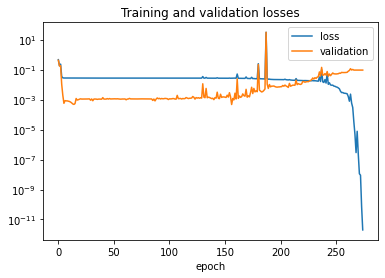

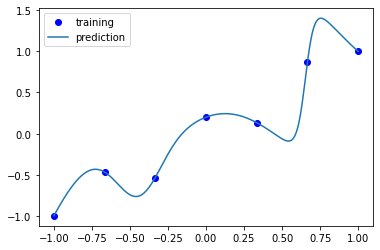

In [12]:
m_val = 0.1

def layer_128():
  return keras.layers.Dense(128, activation='tanh',
            kernel_initializer=tf.random_uniform_initializer(minval=-m_val, maxval=m_val),
            bias_initializer=tf.random_uniform_initializer(minval=-m_val, maxval=m_val)
          )

dnn_large = keras.models.Sequential()
dnn_large.add(keras.layers.InputLayer(input_shape=1))
dnn_large.add(layer_128())
dnn_large.add(layer_128())
dnn_large.add(layer_128())
dnn_large.add(layer_128())
dnn_large.add(keras.layers.Dense(1, activation="linear"))
dnn_large.compile(loss=tf.keras.losses.MeanSquaredError())

model = dnn_large

result = train_DNN(model,x_t,y_t,x_v,y_v,figname='fig/dnn_large_m0p1_loss.png')

# Plot DNN solution
plt.figure()
plt.plot(x_t,y_t,'bo',label='training')
x_p = np.linspace(-1,1,256)
plt.plot(x_p, np.array(model.predict(x_p)).reshape((x_p.size,)), label='prediction')
plt.legend()
plt.savefig('fig/dnn_large_m0p1.png',dpi=300)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 1)                 2         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 2         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________

Convergence information:
loss: 0.0274755097925663
number function evaluations: 129
number iterations: 104
success flag: True
convergence message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


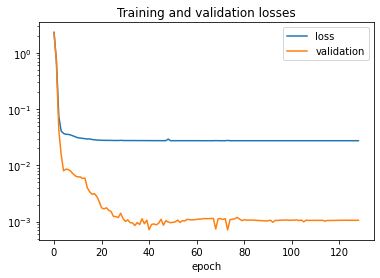

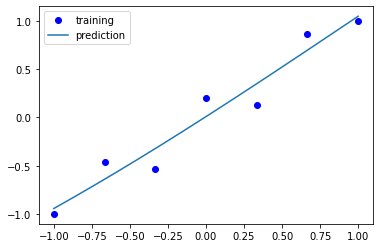

In [13]:
dnn_small = keras.models.Sequential()
dnn_small.add(keras.layers.InputLayer(input_shape=1))
dnn_small.add(keras.layers.Dense(1, activation='tanh'))
dnn_small.add(keras.layers.Dense(1, activation="linear"))
dnn_small.compile(loss=tf.keras.losses.MeanSquaredError())
dnn_small.summary()
model = dnn_small

result = train_DNN(model,x_t,y_t,x_val=x_v,y_val=y_v,
                   figname='fig/dnn_small_loss.png')

# Plot DNN solution
plt.figure()
plt.plot(x_t,y_t,'bo',label='training')
x_p = np.linspace(-1,1,256)
plt.plot(x_p, np.array(model.predict(x_p)).reshape((x_p.size,)), label='prediction')
plt.legend()
plt.savefig('fig/dnn_small.png',dpi=300)


Convergence information:
loss: 0.030597467302141527
number function evaluations: 328
number iterations: 291
success flag: True
convergence message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


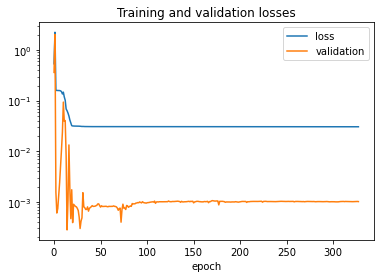

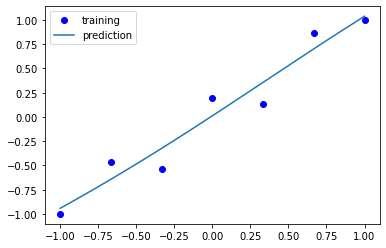

In [14]:
l2reg = 1e-3

regd = keras.models.Sequential()
regd.add(keras.layers.InputLayer(input_shape=1))
regd.add(keras.layers.Dense(128, activation='tanh',
                          kernel_regularizer=tf.keras.regularizers.l2(l=l2reg),
                          bias_regularizer=tf.keras.regularizers.l2(l=l2reg)))
regd.add(keras.layers.Dense(128, activation='tanh',
                          kernel_regularizer=tf.keras.regularizers.l2(l=l2reg),
                          bias_regularizer=tf.keras.regularizers.l2(l=l2reg)))
regd.add(keras.layers.Dense(1, activation="linear",
                          kernel_regularizer=tf.keras.regularizers.l2(l=l2reg),
                          bias_regularizer=tf.keras.regularizers.l2(l=l2reg)))
regd.compile(loss=tf.keras.losses.MeanSquaredError())
model = regd

result = train_DNN(model,x_t,y_t,x_val=x_v,y_val=y_v,
                   figname='fig/dnn_regd_loss.png')

# Plot DNN solution
plt.figure()
plt.plot(x_t,y_t,'bo',label='training')
x_p = np.linspace(-1,1,256)
plt.plot(x_p, np.array(model.predict(x_p)).reshape((x_p.size,)), label='prediction')
plt.legend()
plt.savefig('fig/dnn_regd.png',dpi=300)